In [50]:
%pip install opencv-python

%pip install opencv-python-headless



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np

import matplotlib.pyplot as plt

import cv2

In [52]:
import cv2.version


print(cv2.__version__)

4.10.0


In [134]:
def crop_image_contour_sorry_kiwi(img_gray):
   

    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)

    # Apply binary thresholding
    _, binary_img = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological closing to merge nearby bars
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Adjust kernel size if needed
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    contour_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
    cv2.rectangle(contour_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Adjust the bounding box to shift left and right
    shifted_x = x - 1  # Shift left by 1 pixel
    shifted_w = w + 1  # Increase width by 1 pixel to compensate

    # Ensure the coordinates don't go out of bounds (optional)
    shifted_x = max(0, shifted_x)  # Ensure x doesn't go below 0
    shifted_w = min(img_gray.shape[1] - shifted_x, shifted_w)  # Ensure the width doesn't exceed the image width

    # Crop the image with the adjusted bounding box
    cropped_barcode = img_gray[y:y+h, shifted_x:shifted_x+shifted_w]

    # Display the original image and cropped barcode
 

    plt.imshow(cropped_barcode, cmap='gray')
    plt.title("Cropped Barcode"), plt.axis('off')
  

    return cropped_barcode

In [198]:
from collections import Counter

def find_angle(img_gray):

    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)
    
    edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    angles = []

    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta)  
            angles.append(angle)  
           # print(f"Detected angle: {angle}")
    if angles:
        
        angle_counts = Counter(angles)
        
        
        top_5_angles = angle_counts.most_common(10)
        
        
        print("\nTop 10 most repeated angles:")
        for angle, count in top_5_angles:
    
            print(f"Angle: {angle:.2f} degrees, Count: {count}")

    if top_5_angles[0][0] == 45.00:
        return top_5_angles[1][0]  # Return the second most common angle
    else:
        return top_5_angles[0][0]  # Return the most common angle
    











In [199]:
def rotate_img(img,angle):

    center = (img.shape[1] // 2, img.shape[0] // 2)

    rot_matrix = cv2.getRotationMatrix2D(center,-(180-angle) , 1.0)

    rotated_img = cv2.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))

    return rotated_img



In [49]:

def fill_corners(rotated_img):
    # Make a copy to modify
    filled_image = rotated_img.copy()

    # Define flood fill parameters
    h, w = filled_image.shape
    flood_fill_color = 255  

    # Create a mask for flood fill (2 pixels larger than the image)
    mask = np.zeros((h + 2, w + 2), np.uint8)

   
    cv2.floodFill(filled_image, mask, seedPoint=(0, 0), newVal=flood_fill_color)  # Top-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, 0), newVal=flood_fill_color)  # Top-right corner
    cv2.floodFill(filled_image, mask, seedPoint=(0, h - 1), newVal=flood_fill_color)  # Bottom-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, h - 1), newVal=flood_fill_color)  # Bottom-right corner

    

    return filled_image


In [189]:
import numpy as np
import math

def find_threshold_value(img_gray):
    
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=64, range=(0, 256))
    
    # Total number of pixels in the image
    total_pixels = img_gray.size
    
    # Calculate the number of pixels in the dark region (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  # The first 32 bins correspond to pixel values from 0 to 127

    # Calculate the number of pixels in the bright region (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  # The remaining 32 bins correspond to pixel values from 128 to 255

    # Calculate the percentage of dark and bright pixels
    dark_percentage = dark_pixels / total_pixels
    bright_percentage = bright_pixels / total_pixels

    # Get indices of the top 5 bins with the highest counts, excluding zero bins
    non_zero_indices = np.where(hist_counts > 0)[0] 
    top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]  
    top_5_bins = [bin_edges[non_zero_indices[i]] for i in top_5_indices]

    print(f"Top 5 bins: {top_5_bins}")

    # Calculate the simple average of the top 5 bins

    # Tried weighted average first but this is better apparently and kinda makes sense
    top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]

    # Compute the simple average of the top 5 bins
    average = np.mean(top_5_values)
    print(f"Average of the top 5 bins: {average}")

    if dark_percentage > 0.8:
        print("The image is biased towards dark (0) regions.")
        return math.floor(average)  # Return the threshold for dark-biased images
    elif bright_percentage > 0.8:
        print("The image is biased towards bright (255) regions.")
        return math.floor(average)  # Return the threshold for bright-biased images
    else:
        # Optionally, you can return the average in other cases
        print("The image has a balanced distribution of dark and bright regions.")
        return math.floor(average)




In [ ]:
  # 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
 "00110": "Stop/Start",
 "10001": "1",
 "01001": "2",
 "11000": "3",
 "00101": "4",
 "10100": "5",
 "01100": "6",
 "00011": "7",
 "10010": "8",
 "10000": "9",
 "00001": "0",
 "00100": "-",
}

In [152]:
def get_mean_pixels(cropped_barcode,n):
    
    cropped_barcode = cropped_barcode.astype(np.uint8)

    # Get the mean of the first `n` pixels vertically for each column
    mean = cropped_barcode[-n:, :].mean(axis=0)
        # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    
    

        # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    while pixels and pixels[0] == '0':
        pixels = pixels[1:]



    print(pixels)
    return pixels


In [ ]:
def get_code(pixels):
        # Need to figure out how many pixels represent a narrow bar

    ## Fi moshkela ama el soura cropped akhad pixel wahda zeyada fil awel fa mesh shaghala mesh 3aref da fi kol el sowar wala di bas
    #3amaltaha manual keda lehad mashouf
    narrow_bar_size=0

    for pixel in pixels:
            if pixel == "1":
                narrow_bar_size += 1
            else:
                break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

            if skip_next:
                pixel_index += narrow_bar_size
                skip_next = False
                continue

            count = 1
            try:
                while pixels[pixel_index] == pixels[pixel_index + 1]:
                    count += 1
                    pixel_index += 1
            except:
                pass
            pixel_index += 1

            current_digit_widths += NARROW if count == narrow_bar_size else WIDE

            if current_digit_widths in code11_widths:
                digits.append(code11_widths[current_digit_widths])
                current_digit_widths = ""
                skip_next = True  # Next iteration will be a separator, so skip it

    print(digits)


In [53]:
def read_barcode(cropped_img):
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = cropped_img.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    print(digits)

(600, 800, 3)


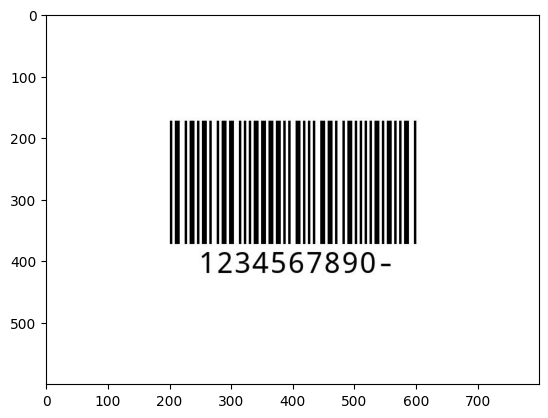

In [32]:
img_gray=cv2.imread("TestCases/01 - lol easy.jpg")

print(img_gray.shape)
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [44]:
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
print(img_gray.shape)
plt.imshow(img_gray,cmap='gray')

error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


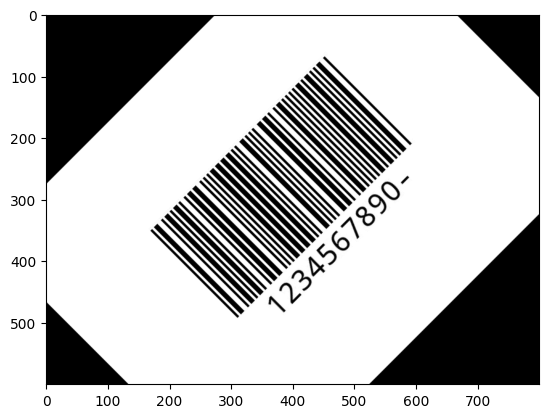

In [47]:
rotated_img=rotate_img(img_gray,225)


plt.imshow(rotated_img,cmap='gray')


Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 88
Angle: 135.00 degrees, Count: 80
Angle: 55.00 degrees, Count: 77
Angle: 35.00 degrees, Count: 76
Angle: 52.00 degrees, Count: 56
Angle: 47.00 degrees, Count: 51
Angle: 41.00 degrees, Count: 50
Angle: 50.00 degrees, Count: 50
Angle: 32.00 degrees, Count: 47
Angle: 58.00 degrees, Count: 44


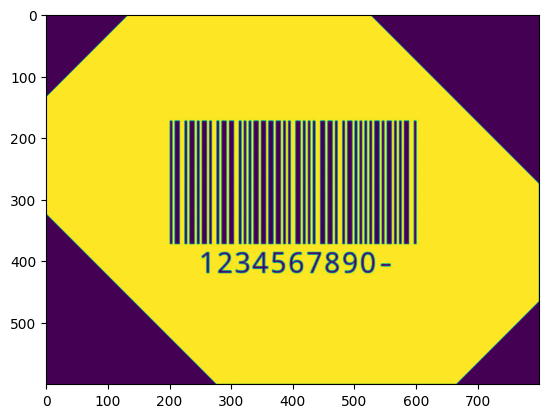

In [48]:
angle=find_angle(rotated_img)
rotated_img=rotate_img(rotated_img,angle)
plt.imshow(rotated_img)

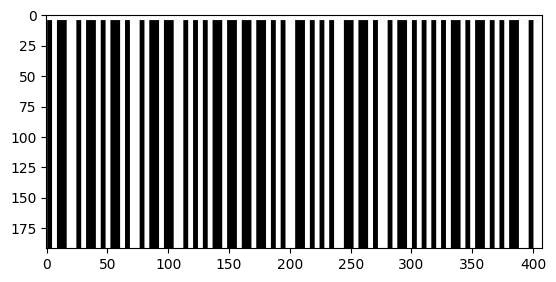

In [309]:
img_inverted=cv2.bitwise_not(img_gray)

x,y,w,h=cv2.boundingRect(img_inverted)

img_cropped=img_gray[y:y+h-h//4 ,x:x+w]

plt.imshow(img_cropped,cmap='gray')


(248, 496, 3)
(600, 800)


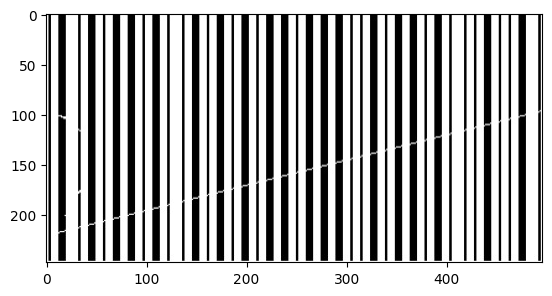

In [300]:
kiwi=cv2.imread("TestCases/kiwi2.jpeg")

print(kiwi.shape)
kiwi_gray = cv2.cvtColor(kiwi, cv2.COLOR_BGR2GRAY)
print(img_gray.shape)
plt.imshow(kiwi_gray,cmap='gray')


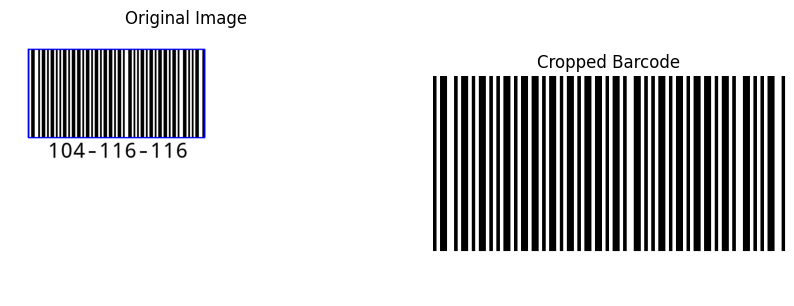

In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
gray_img = cv2.imread("TestCases/02 - still easy.jpg", cv2.IMREAD_GRAYSCALE)

# Apply binary thresholding
_, binary_img = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY_INV)

# Apply morphological closing to merge nearby bars
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Adjust kernel size if needed
closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

# Find contours
contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Identify the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Draw the bounding box
x, y, w, h = cv2.boundingRect(largest_contour)
contour_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
cv2.rectangle(contour_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Adjust the bounding box to shift left and right
shifted_x = x - 1  # Shift left by 1 pixel
shifted_w = w + 1  # Increase width by 1 pixel to compensate

# Ensure the coordinates don't go out of bounds (optional)
shifted_x = max(0, shifted_x)  # Ensure x doesn't go below 0
shifted_w = min(gray_img.shape[1] - shifted_x, shifted_w)  # Ensure the width doesn't exceed the image width

# Crop the image with the adjusted bounding box
cropped_barcode = gray_img[y:y+h, shifted_x:shifted_x+shifted_w]

# Display the original image and cropped barcode
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image"), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(cropped_barcode, cmap='gray')
plt.title("Cropped Barcode"), plt.axis('off')
plt.show()


In [94]:
# Get the average of each column in your image
mean = cropped_barcode.mean(axis=0)

    # Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))
print(pixels)

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011111111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110


In [96]:
  # Need to figure out how many pixels represent a narrow bar

## Fi moshkela ama el soura cropped akhad pixel wahda zeyada fil awel fa mesh shaghala mesh 3aref da fi kol el sowar wala di bas
 #3amaltaha manual keda lehad mashouf
narrow_bar_size=0

for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


(600, 800, 3)


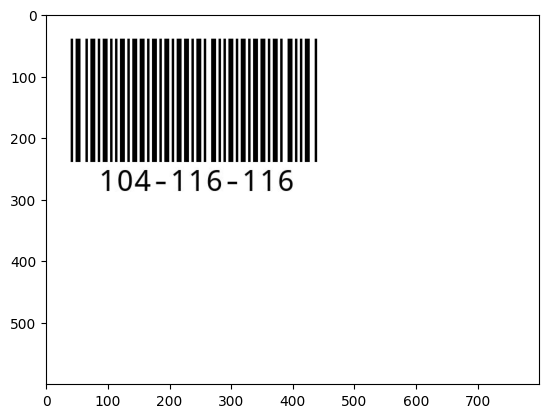

In [18]:
img2=cv2.imread("TestCases/02 - still easy.jpg")

print(img2.shape)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb2)

(600, 800)


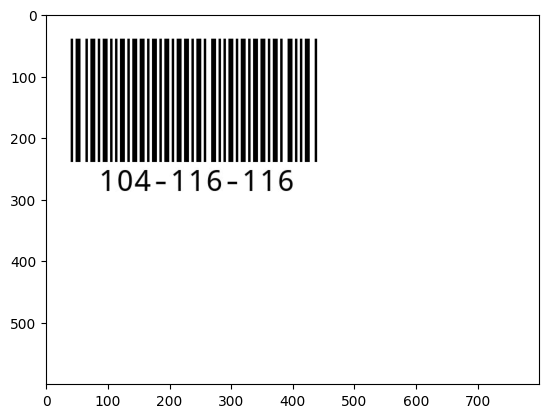

In [19]:
img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
print(img_gray2.shape)
plt.imshow(img_gray2,cmap='gray')

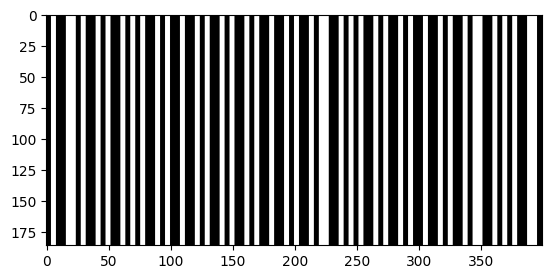

In [104]:
img_inverted2=cv2.bitwise_not(img_gray2)

x,y,w,h=cv2.boundingRect(img_inverted2)

img_cropped2=img_gray2[y:y+h-h//4 ,x:x+w]

plt.imshow(img_cropped2,cmap='gray')

In [105]:
# Get the average of each column in your image
mean = img_cropped2.mean(axis=0)

    # Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))
print(pixels)

1111000011111111000000001111000011111111000011110000111111110000111100001111000011111111000011110000111111110000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000111100001111111100001111000011111111000011111111000011110000111111110000111100000000111111110000111100001111000011111111000000001111


In [113]:
  # Need to figure out how many pixels represent a narrow bar
narrow_bar_size =0
## Fi moshkela ama el soura cropped akhad pixel wahda zeyada fil awel fa mesh shaghala mesh 3aref da fi kol el sowar wala di bas
 #3amaltaha manual keda lehad mashouf
 

for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


                                            FREQUENCY DOMAIN 

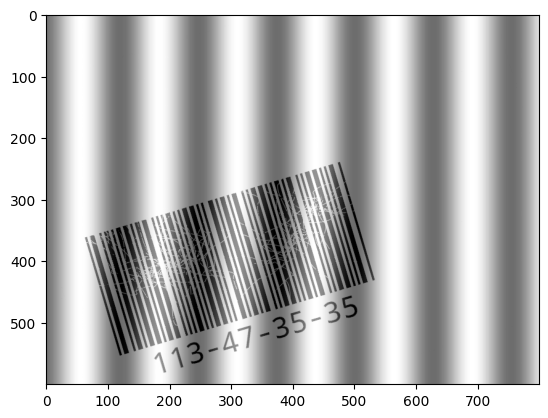

In [83]:
img3=cv2.imread("TestCases/11 - bayza 5ales di bsara7a.jpg")
img_gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray3,cmap='gray')


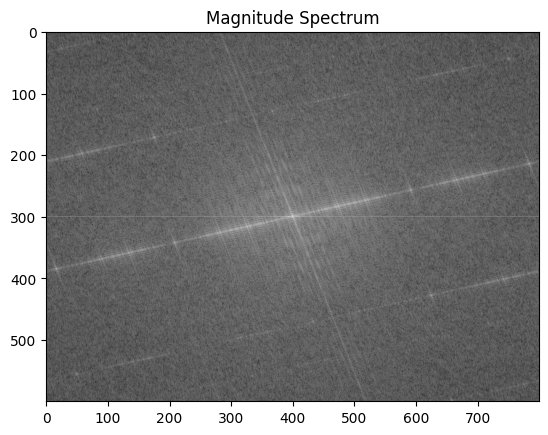

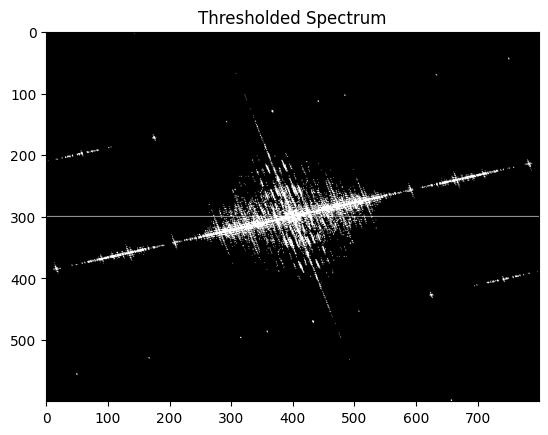

240400    18.219312
240394    16.514972
240406    16.514972
240393    15.752532
240407    15.752532
239600    15.126096
241200    15.126096
240395    15.116160
240405    15.116160
239599    14.911293
dtype: float64


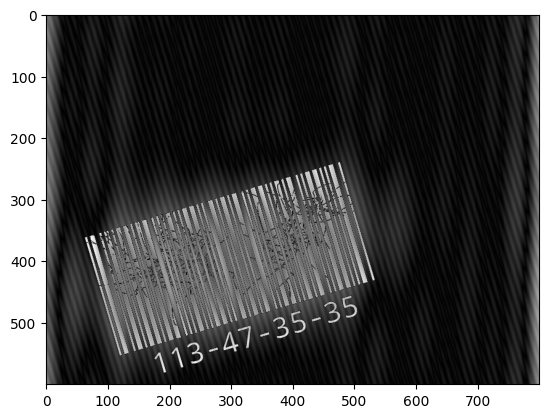

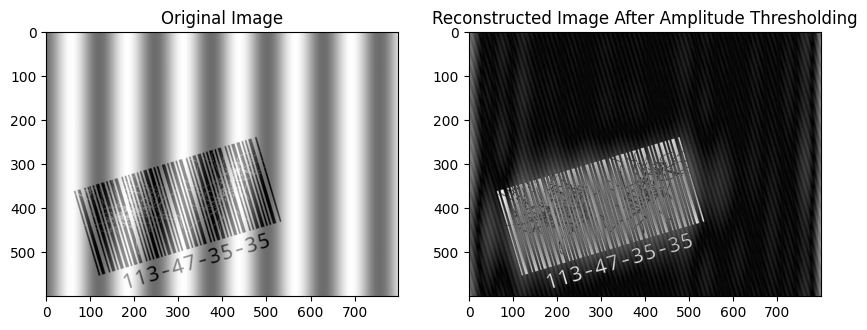

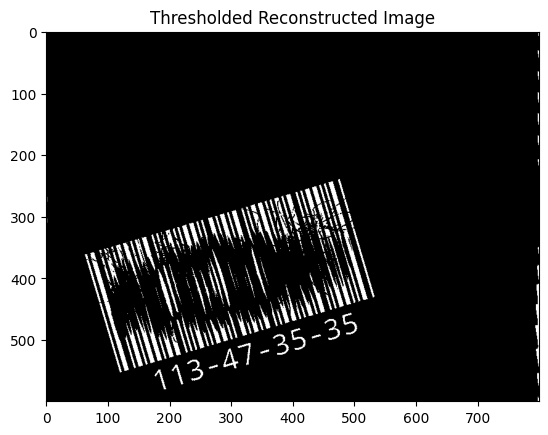

In [245]:
# dft_img=np.fft.fft2(img_gray3)
# dft_img_shift = np.fft.fftshift(dft_img)
# plt.imshow(np.log(np.abs(dft_img_shift)), cmap = 'gray')
# amplitude_spectrum = np.abs(dft_img_shift)
# _, binary_spectrum = cv2.threshold(amplitude_spectrum, 30, 255, cv2.THRESH_BINARY)
# plt.imshow(binary_spectrum, cmap='gray')
# plt.title('Binarized Spectrum')
# plt.show()
# #print(amplitude_spectrum)
dft_img = np.fft.fft2(img_gray3)  # Assuming img_gray is the grayscale barcode image
dft_shift = np.fft.fftshift(dft_img)
magnitude_spectrum = np.log(np.abs(dft_shift))


plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()
_, thresh = cv2.threshold(magnitude_spectrum, 10, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Spectrum')
plt.show()



# Apply Canny edge detection
edges = cv2.Canny(img_gray3, 50, 150, apertureSize=3)

# Apply Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

plt.imshow(edges,cmap='gray')
import pandas as pd

# Convert the amplitude spectrum array to a DataFrame
magnitude_df = pd.DataFrame(magnitude_spectrum)

# Flatten the DataFrame and get the top 10 values
top_10_amplitudes = magnitude_df.values.flatten()  # Flatten to a 1D array
top_10_values = pd.Series(top_10_amplitudes).nlargest(10)

# Print top 10 amplitudes
print(top_10_values)


threshold = 14.05 # Set your desired amplitude threshold
filtered_dft = dft_shift.copy()
filtered_dft[magnitude_spectrum > threshold] = 0  # Zero out high-amplitude frequencies

# Step 5: Inverse shift and inverse DFT
filtered_dft[0, 0] = dft_shift[0, 0]  # Restore the DC component after filtering

dft_img_ishift = np.fft.ifftshift(filtered_dft)
img_reconstructed = np.fft.ifft2(dft_img_ishift)
img_reconstructed = np.abs(img_reconstructed)
img_reconstructed = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(img_reconstructed, cmap='gray')



# Step 6: Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img3, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image After Amplitude Thresholding")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()


# Apply threshold to reconstructed image: values above 200 become 255, below 200 become 0
threshold_value = 140
_, binary_img = cv2.threshold(img_reconstructed, threshold_value, 255, cv2.THRESH_BINARY)

# Show the result
plt.imshow(binary_img, cmap='gray')
plt.title('Thresholded Reconstructed Image')
plt.show()




In [246]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def connect_vertical_bars(binary_img, kernel_height=20):
    """
    Connect vertical bars of the same color in a binary image.
    
    Args:
        binary_img (numpy.ndarray): Binary image with vertical bars.
        kernel_height (int): Height of the structuring element to connect vertical bars.

    Returns:
        numpy.ndarray: Image with connected vertical bars.

    """

    _,inverted_img = cv2.threshold(binary_img,128,255,cv2.THRESH_BINARY_INV)


    # Create a vertical kernel
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_height))

    # Apply morphological closing to connect vertical bars
    connected_img = cv2.morphologyEx(inverted_img, cv2.MORPH_CLOSE, vertical_kernel)

    connected_img=cv2.bitwise_not(connected_img)
    return connected_img




Top 10 most repeated angles:
Angle: 163.00 degrees, Count: 6
Angle: 73.00 degrees, Count: 2
Angle: 74.00 degrees, Count: 2
Angle: 45.00 degrees, Count: 2
Angle: 0.00 degrees, Count: 1
Angle: 164.00 degrees, Count: 1
11110000111111110000000011110000111111110000111100001111111100001111111100001111000011111111000011111111000000001111000011110000111100001111111100001111000011110000111111110000111111110000111100001111000000001111111100001111000011111111000011110000111111110000000011110000111100001111111100001111111100001111000011110000111111110000111100001111111100000000111100001111000011111111000011111111000011110000111100001111111100000000111100
['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']


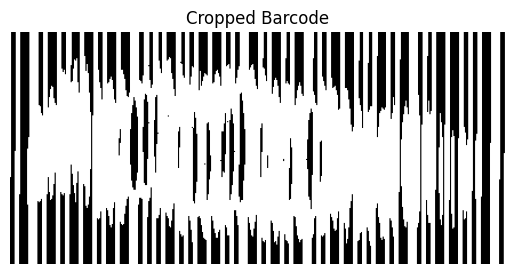

In [294]:
angle =find_angle(binary_img)


rotated_img=rotate_img(binary_img,angle)


_,rotated_img=cv2.threshold(rotated_img,128,255,cv2.THRESH_BINARY_INV)


#rotated_img=connect_vertical_bars(rotated_img,20)

cropped_img=crop_image_contour_sorry_kiwi(rotated_img)

cropped_img=connect_vertical_bars(cropped_img,40)


plt.imshow(cropped_img,cmap='gray')

pixels=get_mean_pixels(cropped_img,2)
code=get_code(pixels)





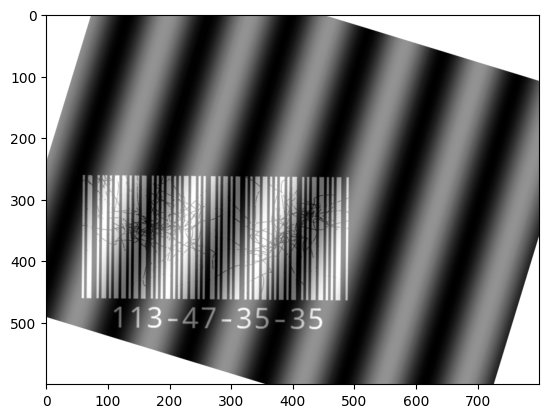

In [85]:
img_inverted2=cv2.bitwise_not(rotated_img)

plt.imshow(img_inverted2,cmap='gray')



In [216]:
import cv2
import numpy as np
from collections import Counter

# Assuming 'thresh' is your thresholded image
#lines = cv2.HoughLines(thresh.astype(np.uint8), 1, np.pi / 180, threshold=100)

# Initialize an empty list to store angles
angles = []

if lines is not None:
    for rho, theta in lines[:, 0]:
        angle = np.degrees(theta)  # Convert angle to degrees
        angles.append(angle)  # Add the angle to the list
        print(f"Detected angle: {angle}")

# Check if there are any angles detected
if angles:
    # Count how many times each angle appears
    angle_counts = Counter(angles)
    
    # Get the top 5 most common angles
    top_5_angles = angle_counts.most_common(5)
    
    # Display the top 5 most common angles with their counts
    print("\nTop 5 most repeated angles:")
    for angle, count in top_5_angles:
        print(f"Angle: {angle:.2f} degrees, Count: {count}")
else:
    print("No lines detected.")



Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 65.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 162.99998474121094
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 63.999996185302734
Detected angle: 63.999996185302734
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 90.99999237060547
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 89.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 45.0
Detected angle: 57.999996185302734
Detected angle: 67.99999237060547
Detected angle: 69.99999237060547
Detected angle: 71.0
Detected angle: 73.99999237060547
Detected angle: 87.99999237060547
Detected angle: 91.99999237060547
Detec

(600, 800, 3)


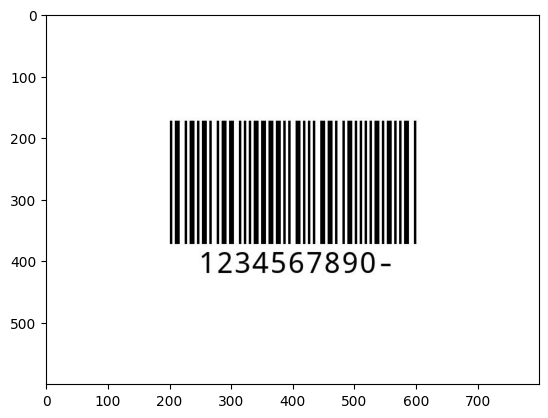

In [ ]:
img_gray=cv2.imread("TestCases/01 - lol easy.jpg")

print(img_gray.shape)
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

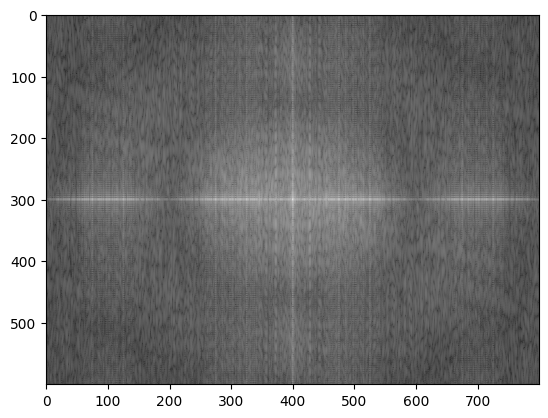

In [145]:
dft_img2=np.fft.fft2(img_gray)
dft_img_shift2 = np.fft.fftshift(dft_img2)
plt.imshow(np.log(np.abs(dft_img_shift2)), cmap = 'gray')
amplitude_spectrum2 = np.abs(dft_img_shift2)

In [147]:
import pandas as pd

# Convert the amplitude spectrum array to a DataFrame
amplitude_df = pd.DataFrame(amplitude_spectrum)

# Flatten the DataFrame and get the top 10 values
top_10_amplitudes = amplitude_df.values.flatten()  # Flatten to a 1D array
top_10_values = pd.Series(top_10_amplitudes).nlargest(10)

# Print top 10 amplitudes
print(top_10_values)



240400    1.104382e+08
239600    9.458139e+06
241200    9.458139e+06
240401    7.711902e+06
240399    7.711902e+06
239601    6.058710e+06
241199    6.058710e+06
241201    6.015471e+06
239599    6.015471e+06
238800    3.982920e+06
dtype: float64


In [146]:
# Convert the amplitude spectrum array to a DataFrame
amplitude_df = pd.DataFrame(amplitude_spectrum2)

# Display the first few rows of the DataFrame
print(amplitude_df.nlargest(10,10))  # Print top 10 rows for readability


             0             1            2             3            4    \
300  2881.000000  28874.584801  3363.850302  28130.645090  4269.444924   
299  2090.472846  25867.999873  4456.910709  21790.654177  5193.048584   
301  2090.472846  24072.377601   346.712937  24189.259504  1326.397455   
373  1764.554045   2234.515871  2061.222197   2035.310379  1734.313007   
370  1397.887112   1853.427167  1857.822753   1879.296958  1112.265191   
372   584.791653   1125.721561  1968.087596   2075.243444  1229.405671   
371  2143.035143   2331.467792  1824.761999   1518.413062  1512.085827   
375   606.221103   1304.065478  2163.670302   2464.601316  1612.245914   
374  1632.441620   1805.840035  1995.838693   1963.830617  1740.966566   
369  1495.160091   1605.308799  1621.290913   1368.768410   839.446134   

              5            6             7             8             9    ...  \
300  32535.171949  8021.931556  36445.237746  15162.149168  14918.672310  ...   
299  24075.352178  9751

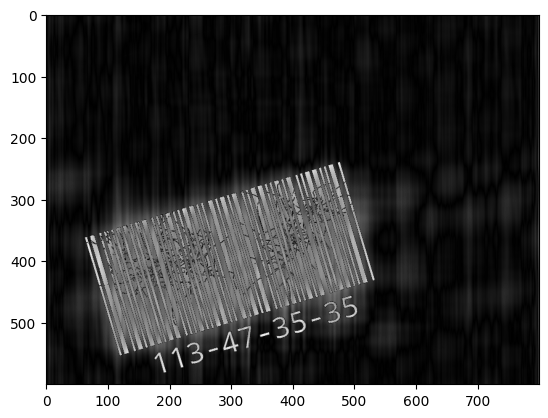

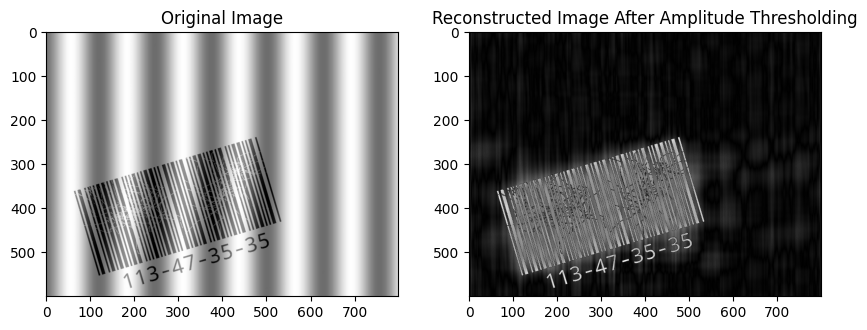

In [169]:
# Step 4: Apply amplitude threshold (zero out high-amplitude components)
threshold = 2.6e+05 # Set your desired amplitude threshold
filtered_dft = dft_img_shift.copy()
filtered_dft[amplitude_spectrum > threshold] = 0  # Zero out high-amplitude frequencies

# Step 5: Inverse shift and inverse DFT
filtered_dft[0, 0] = dft_img_shift[0, 0]  # Restore the DC component after filtering

dft_img_ishift = np.fft.ifftshift(filtered_dft)
img_reconstructed = np.fft.ifft2(dft_img_ishift)
img_reconstructed = np.abs(img_reconstructed)
img_reconstructed = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(img_reconstructed, cmap='gray')



# Step 6: Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img3, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image After Amplitude Thresholding")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()


In [131]:
%pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB 1.9 MB/s eta 0:00:07
   ---------------------------------------- 0.1/12.8 MB 1.6 MB/s eta 0:00:08
    --------------------------------------- 0.2/12.8 MB 1.9 MB/s eta 0:00:07
    --------------------------------------- 0.3/12.8 MB 2.1 MB/s eta 0:00:06
   - -------------------------------------- 0.5/12.8 MB 2.5 MB/s eta 0:00:05
   - -------------------------------------- 0.6/12.8 MB 2.4 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/12.8 MB 2.2 MB/s eta 0:00:06
   -- ------------------------------------- 0.8/12.8 MB 2.2 MB/s eta 0:00:06
   -- ------------------------------------- 0.9/12.8 MB 2.2 MB/s eta 0:00:06
   -- ------------------------------------- 0.9/12.8 MB 2.2 MB/s eta 0:00:06
   ---- ----------------------------------- 1.4/12.8 MB 2.8 MB/s eta 0:00:05
   ---- ----------------------------------- 1.4/12.8 MB 2.8 MB/s eta 0:00:05
   ---

  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


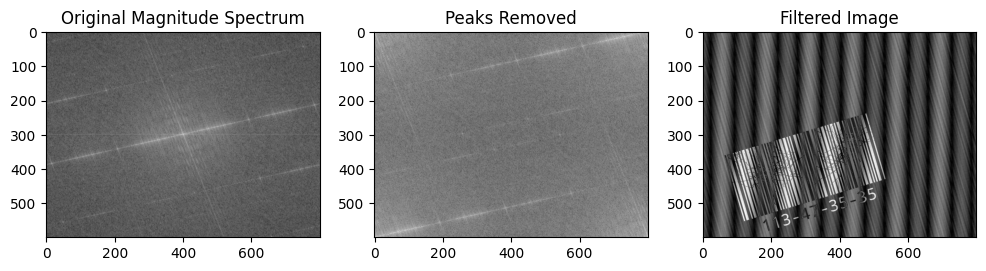

In [ ]:
# import cv2
# import numpy as np
# from skimage.feature import peak_local_max
# import matplotlib.pyplot as plt

# # Load the image (grayscale)
# image = cv2.imread('TestCases/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)

# # Perform DFT (Discrete Fourier Transform) and shift zero frequency to the center
# dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
# dft_shift = np.fft.fftshift(dft)

# # Compute magnitude spectrum
# magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
# magnitude_spectrum = 20 * np.log(np.abs(magnitude) + 1)

# # Normalize for better visualization
# normalized_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)

# # Detect peaks in 2D using skimage
# coordinates = peak_local_max(normalized_spectrum, min_distance=7, threshold_rel=0.1)



# # Suppress peaks (set their values to 0)
# for coord in coordinates:
#     x, y = coord
#     dft_shift[x, y] = 0  # Suppress both real and imaginary parts

# # Inverse DFT to return to spatial domain
# dft_shift = np.fft.ifftshift(dft_shift)  # Shift back
# filtered_image = cv2.idft(dft_shift)
# filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# # filtered_image_normalized = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)

# # threshold_value=130

# # _,filtered_image_thresholded=cv2.threshold(filtered_image_normalized,threshold_value,255,cv2.THRESH_BINARY)

# # Plot results
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 3, 1)
# plt.title("Original Magnitude Spectrum")
# plt.imshow(magnitude_spectrum, cmap='gray')

# plt.subplot(1, 3, 2)
# plt.title("Peaks Removed")
# plt.imshow(np.log(1 + cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])), cmap='gray')

# plt.subplot(1, 3, 3)
# plt.title("Filtered Image")
# plt.imshow(filtered_image_normalized, cmap='gray')
# plt.show()




Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25
Angle: 80.00 degrees, Count: 24
Angle: 64.00 degrees, Count: 23
Angle: 78.00 degrees, Count: 22
Angle: 73.00 degrees, Count: 22
Angle: 90.00 degrees, Count: 22


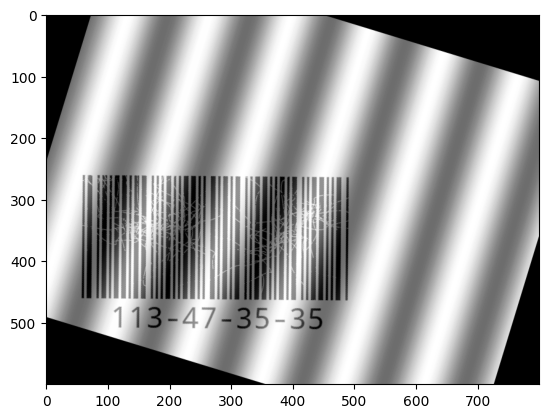

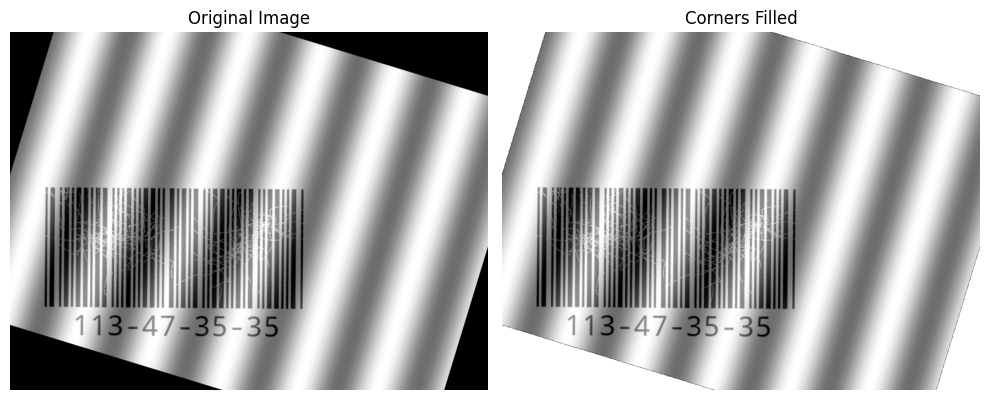

Top 5 bins: [0.0, 4.0, 8.0, 12.0, 44.0]
Average of the top 5 bins: 15.600000381469727
The image is biased towards dark (0) regions.


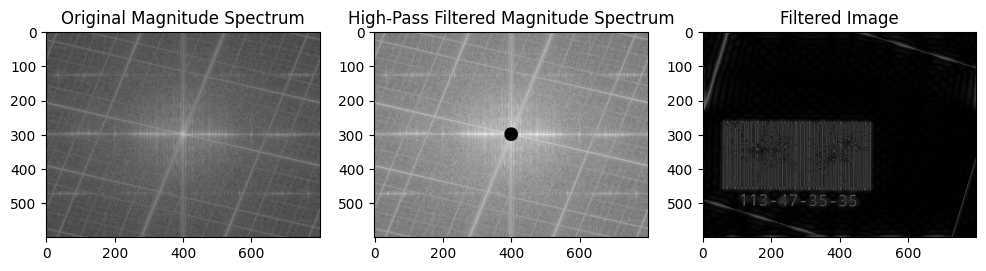

In [80]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt

# Load the image (grayscale)
image = cv2.imread('TestCases/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)


angle=find_angle(image)

rotated_img=rotate_img(image,angle)



plt.imshow(rotated_img,cmap='gray')

filled_image=fill_corners(rotated_img)



# Perform DFT (Discrete Fourier Transform) and shift zero frequency to the center
dft = cv2.dft(np.float32(filled_image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Compute magnitude spectrum
magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
magnitude_spectrum = 20 * np.log(np.abs(magnitude) + 1)

# Normalize for better visualization (now we use normalized magnitude)
normalized_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)

# Create a high-pass filter mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # center of the image
radius = 20  # Set the radius of the low-pass region to zero out

# Create a mask with a high-pass filter (set low frequencies to zero)
mask = np.ones((rows, cols, 2), np.uint8)  # Initialize a mask with ones
center = [crow, ccol]
cv2.circle(mask, (center[1], center[0]), radius, (0, 0, 0), -1)  # Set the low-frequency part to 0

# Apply the high-pass filter mask to the DFT shifted image
dft_shift_filtered = dft_shift * mask

# Inverse DFT to return to spatial domain
dft_shift_inv = np.fft.ifftshift(dft_shift_filtered)  # Shift back
filtered_image = cv2.idft(dft_shift_inv)
filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Normalize the filtered image before thresholding (optional)
filtered_image_normalized = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)

# Threshold the normalized filtered image (after inverse DFT)
threshold_value=find_threshold_value(filtered_image_normalized)
#_, filtered_image_thresholded = cv2.threshold(filtered_image_normalized, 40, 255, cv2.THRESH_BINARY_INV)

#filtered_image_thresholded_inverted=cv2.bitwise_not(filtered_image_thresholded)

# Plot results
plt.figure(figsize=(12, 6))

# Original Magnitude Spectrum
plt.subplot(1, 3, 1)
plt.title("Original Magnitude Spectrum")
plt.imshow(magnitude_spectrum, cmap='gray')

# High-Pass Filtered Magnitude Spectrum  
plt.subplot(1, 3, 2)
plt.title("High-Pass Filtered Magnitude Spectrum")
plt.imshow(np.log(1 + cv2.magnitude(dft_shift_filtered[:, :, 0], dft_shift_filtered[:, :, 1])), cmap='gray')

# Filtered Image after Thresholding
plt.subplot(1, 3, 3)
plt.title("Filtered Image")
plt.imshow(filtered_image_normalized, cmap='gray')

plt.show()


In [81]:
cropped_img=crop_image_contour_sorry_kiwi(filtered_image_thresholded)



error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours_new.cpp:330: error: (-2:Unspecified error) in function 'class std::shared_ptr<struct ContourScanner_> __cdecl ContourScanner_::create(class cv::Mat,int,int,class cv::Point_<int>)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 5 (CV_32FC1)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


In [12]:
def crop_edges_black(thresholded_edges):
    # Convert the image to a binary array (0s and 255s)
    binary_image = thresholded_edges

    # Get the number of rows (height) and columns (width)
    height, width = binary_image.shape

    # Find the first and last black pixels for each row (black = 0)
    left_crop = np.zeros(height, dtype=int)
    right_crop = np.zeros(height, dtype=int)

    for row in range(height):
        row_data = binary_image[row]
        left_crop[row] = np.argmax(row_data == 0)  # First black pixel in the row
        right_crop[row] = width - np.argmax(row_data[::-1] == 0) - 1  # Last black pixel in the row

    # Determine the leftmost and rightmost pixels across all rows
    left_most = np.min(left_crop[left_crop > 0])  # Ignore zero values
    right_most = np.max(right_crop[right_crop > 0])  # Ignore zero values

    # Crop the image based on the determined left and right boundaries
    cropped_image = binary_image[:, left_most:right_most]

    return cropped_image



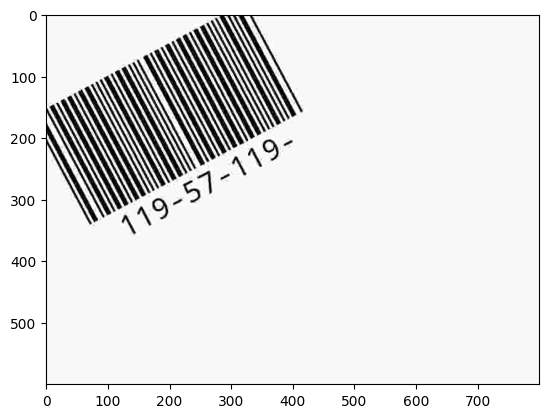

In [22]:
img5=cv2.imread("TestCases/09 - e3del el soora ya3ammm.jpg")
img_gray5 = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray5,cmap='gray')

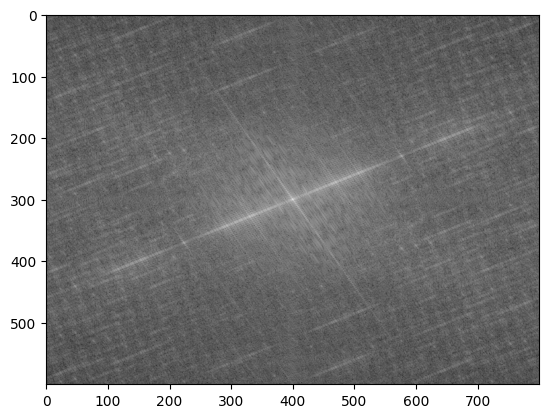

In [256]:
dft_img3=np.fft.fft2(img_gray5)
dft_img_shift3 = np.fft.fftshift(dft_img3)
plt.imshow(np.log(np.abs(dft_img_shift3)+1), cmap = 'gray')
amplitude_spectrum3 = np.abs(dft_img_shift2)

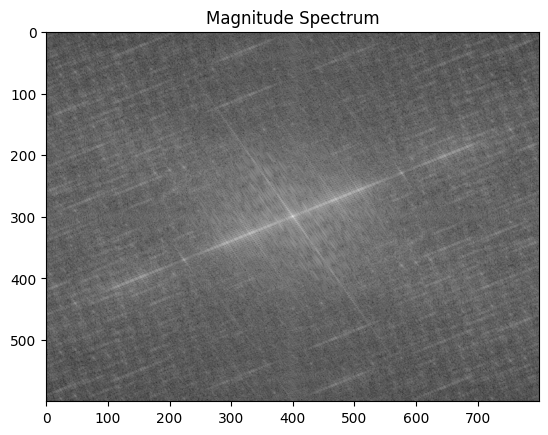

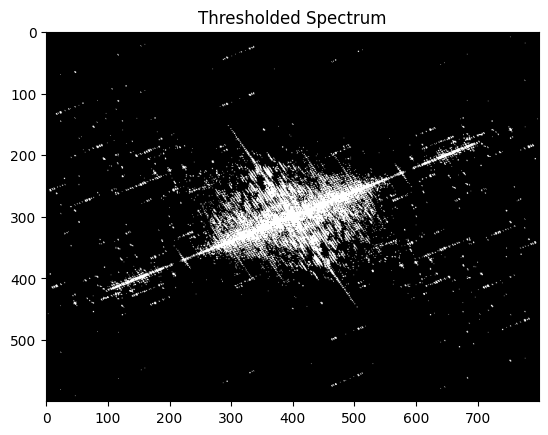

In [272]:

magnitude_spectrum2 = np.log(np.abs(dft_img_shift3) + 1)


plt.imshow(magnitude_spectrum2, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()
_, thresh2 = cv2.threshold(magnitude_spectrum2, 10, 255, cv2.THRESH_BINARY)
plt.imshow(thresh2, cmap='gray')
plt.title('Thresholded Spectrum')
plt.show()






In [9]:




from collections import Counter

# Assuming 'thresh' is your thresholded image
lines = cv2.HoughLines(thresh2.astype(np.uint8), 1, np.pi / 180, threshold=100)

# Initialize an empty list to store angles
angles = []

if lines is not None:
    for rho, theta in lines[:, 0]:
        angle = np.degrees(theta)  # Convert angle to degrees
        angles.append(angle)  # Add the angle to the list
        print(f"Detected angle: {angle}")

# Check if there are any angles detected
if angles:
    # Count how many times each angle appears
    angle_counts = Counter(angles)
    
    # Get the top 5 most common angles
    top_5_angles = angle_counts.most_common(5)
    
    # Display the top 5 most common angles with their counts
    print("\nTop 5 most repeated angles:")
    for angle, count in top_5_angles:
        print(f"Angle: {angle:.2f} degrees, Count: {count}")
else:
    print("No lines detected.")

NameError: name 'thresh2' is not defined

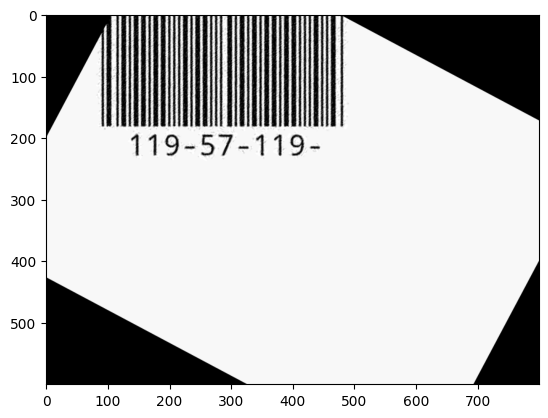

In [ ]:
center2 = (img5.shape[1] // 2, img5.shape[0] // 2)

# Get the rotation matrix
rot_matrix2 = cv2.getRotationMatrix2D(center2, -28, 1.0)

# Rotate the image using the rotation matrix
rotated_img2 = cv2.warpAffine(img5, rot_matrix2, (img_gray.shape[1], img_gray.shape[0]))




plt.imshow(rotated_img2)

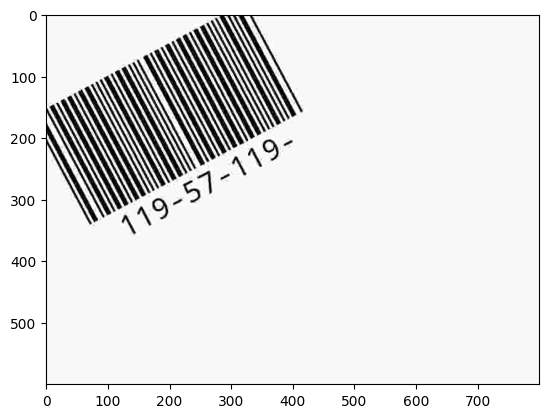

In [278]:
plt.imshow(img_gray5,cmap='gray')

In [283]:
# Apply Canny edge detection
edges = cv2.Canny(img_gray5, 50, 150, apertureSize=3)

# Apply Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)


# Initialize an empty list to store angles
angles = []

if lines is not None:
    for rho, theta in lines[:, 0]:
        angle = np.degrees(theta)  # Convert angle to degrees
        angles.append(angle)  # Add the angle to the list
        print(f"Detected angle: {angle}")

# Check if there are any angles detected
if angles:
    # Count how many times each angle appears
    angle_counts = Counter(angles)
    
    # Get the top 5 most common angles
    top_5_angles = angle_counts.most_common(5)
    
    # Display the top 5 most common angles with their counts
    print("\nTop 5 most repeated angles:")
    for angle, count in top_5_angles:
        print(f"Angle: {angle:.2f} degrees, Count: {count}")
else:
    print("No lines detected.")

Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.99998474121094
Detected angle: 151.

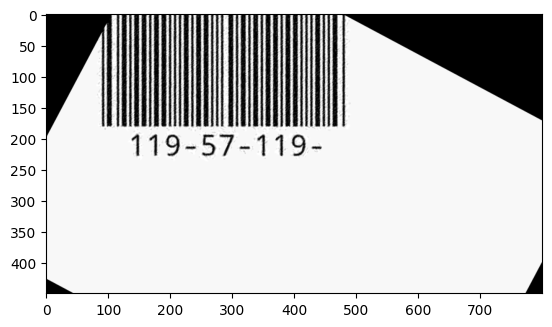

In [295]:
# Convert to grayscale if needed
img_gray4 = cv2.cvtColor(rotated_img2, cv2.COLOR_BGR2GRAY)

# Invert the image if necessary (if you want white as foreground)
img_inverted4 = cv2.bitwise_not(img_gray4)

# Threshold to get a binary image
_, img_inverted4 = cv2.threshold(img_inverted4, 127, 255, cv2.THRESH_BINARY)

# Now find the bounding rectangle
x, y, w, h = cv2.boundingRect(img_inverted4)

# Crop the image based on the bounding box
img_cropped4 = img_gray4[y:y + h - h // 4, x:x + w]

# Display the cropped image
plt.imshow(img_cropped4, cmap='gray')

In [42]:
angle=find_angle(img_gray2)

edges = cv2.Canny(img_gray5, 50, 150, apertureSize=3)

plt.imshow(edges,cmap='gray')

print(angle[0][0])

NameError: name 'img_gray2' is not defined


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 77
Angle: 58.00 degrees, Count: 5
Angle: 72.00 degrees, Count: 5
Angle: 122.00 degrees, Count: 4
Angle: 70.00 degrees, Count: 4
Angle: 71.00 degrees, Count: 3
Angle: 45.00 degrees, Count: 3
Angle: 68.00 degrees, Count: 3
Angle: 69.00 degrees, Count: 3
Angle: 73.00 degrees, Count: 3


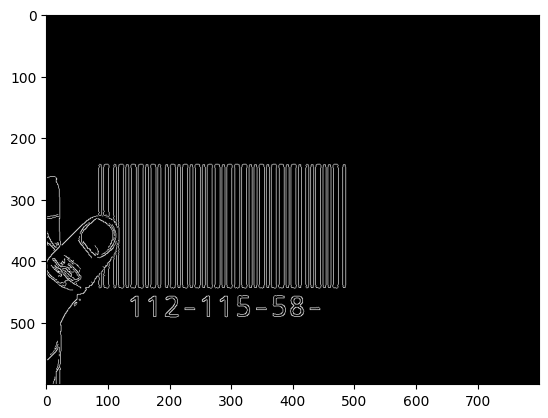

In [37]:
finger_img=cv2.imread("TestCases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg")

finger_img_gray=cv2.cvtColor(finger_img, cv2.COLOR_BGR2GRAY)

find_angle(finger_img_gray)

edges = cv2.Canny(finger_img_gray, 50, 150, apertureSize=3)

plt.imshow(edges,cmap='gray')


Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25
Angle: 80.00 degrees, Count: 24
Angle: 64.00 degrees, Count: 23
Angle: 78.00 degrees, Count: 22
Angle: 73.00 degrees, Count: 22
Angle: 90.00 degrees, Count: 22


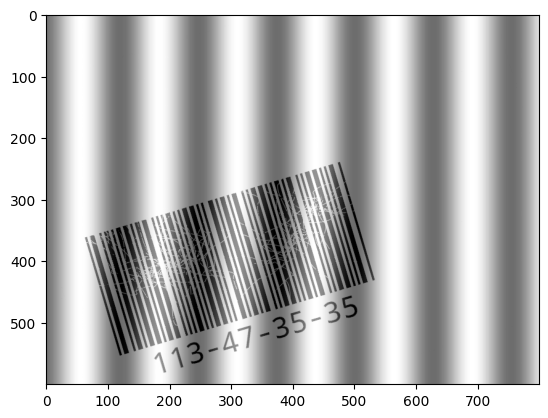

In [78]:
img3=cv2.imread("TestCases/11 - bayza 5ales di bsara7a.jpg")
img_gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

find_angle(img_gray3)

plt.imshow(img_gray3,cmap='gray')


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 45.00 degrees, Count: 4
Angle: 90.00 degrees, Count: 3
Angle: 58.00 degrees, Count: 2
Angle: 122.00 degrees, Count: 2
Processed 01 - lol easy.jpg: Angle - 0.0


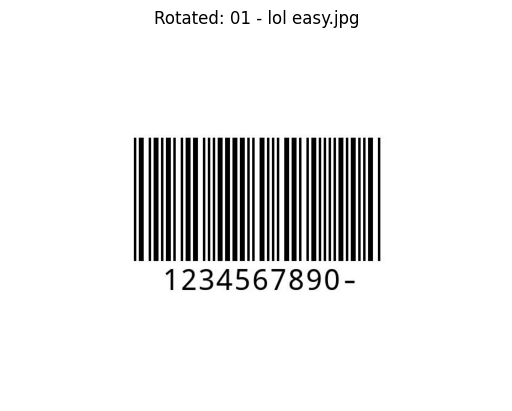


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 58.00 degrees, Count: 4
Angle: 122.00 degrees, Count: 3
Angle: 90.00 degrees, Count: 2
Angle: 1.00 degrees, Count: 1
Angle: 45.00 degrees, Count: 1
Processed 02 - still easy.jpg: Angle - 0.0


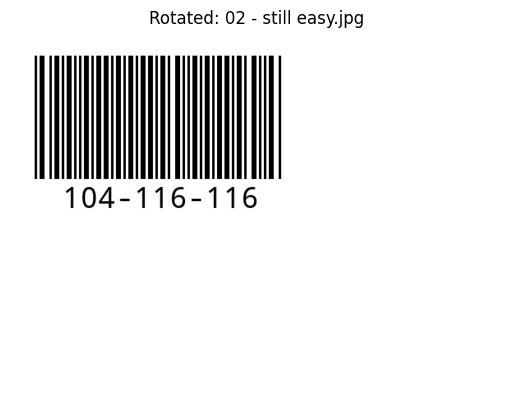


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 77
Angle: 58.00 degrees, Count: 5
Angle: 72.00 degrees, Count: 5
Angle: 122.00 degrees, Count: 4
Angle: 70.00 degrees, Count: 4
Angle: 69.00 degrees, Count: 4
Angle: 71.00 degrees, Count: 3
Angle: 45.00 degrees, Count: 3
Angle: 68.00 degrees, Count: 3
Angle: 73.00 degrees, Count: 3
Processed 03 - eda ya3am ew3a soba3ak mathazarsh.jpg: Angle - 0.0


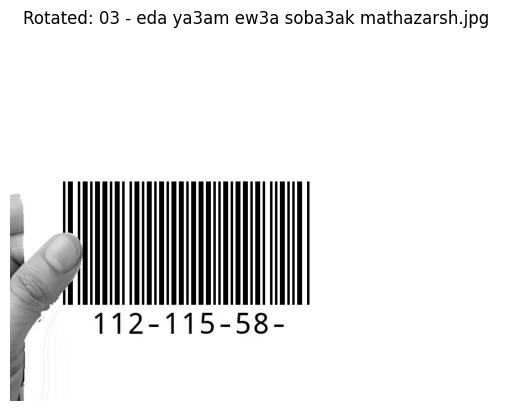


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 90.00 degrees, Count: 2
Angle: 1.00 degrees, Count: 1
Processed 04 - fen el nadara.jpg: Angle - 0.0


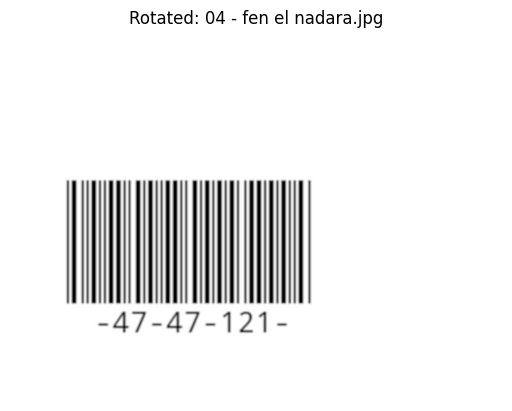

error handling
error handling

Top 10 most repeated angles:
Angle: 135.00 degrees, Count: 333
Angle: 45.00 degrees, Count: 332
Angle: 179.00 degrees, Count: 201
Angle: 0.00 degrees, Count: 199
Angle: 58.00 degrees, Count: 190
Angle: 32.00 degrees, Count: 190
Angle: 13.00 degrees, Count: 180
Angle: 24.00 degrees, Count: 179
Angle: 11.00 degrees, Count: 179
Angle: 14.00 degrees, Count: 178
Processed 07 - mal7 w felfel.jpg: Angle - 135.0


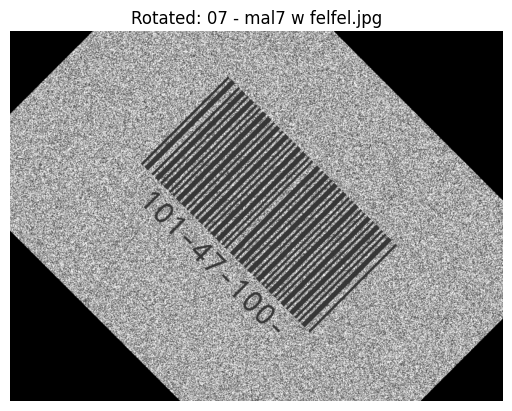


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 102
Angle: 45.00 degrees, Count: 70
Angle: 135.00 degrees, Count: 69
Angle: 97.00 degrees, Count: 46
Angle: 58.00 degrees, Count: 40
Angle: 122.00 degrees, Count: 37
Angle: 96.00 degrees, Count: 37
Angle: 83.00 degrees, Count: 33
Angle: 98.00 degrees, Count: 32
Angle: 99.00 degrees, Count: 32
Processed 08 - compresso espresso.jpg: Angle - 0.0


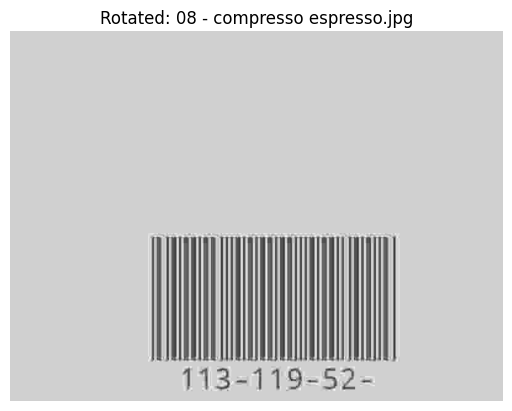


Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 80
Angle: 152.00 degrees, Count: 78
Angle: 58.00 degrees, Count: 45
Angle: 65.00 degrees, Count: 42
Angle: 62.00 degrees, Count: 39
Angle: 64.00 degrees, Count: 39
Angle: 76.00 degrees, Count: 38
Angle: 71.00 degrees, Count: 38
Angle: 60.00 degrees, Count: 37
Angle: 68.00 degrees, Count: 37
Processed 09 - e3del el soora ya3ammm.jpg: Angle - 151.99998474121094


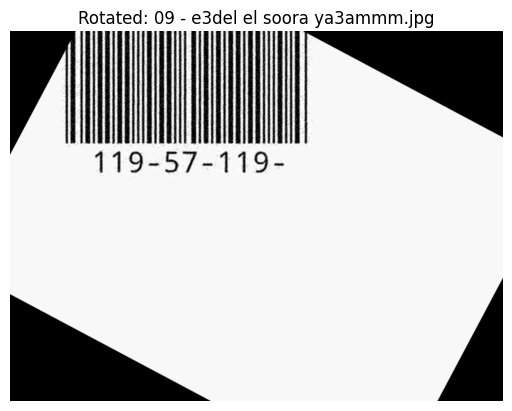

error handling

Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25
Angle: 80.00 degrees, Count: 24
Angle: 64.00 degrees, Count: 23
Angle: 78.00 degrees, Count: 22
Angle: 73.00 degrees, Count: 22
Angle: 90.00 degrees, Count: 22
Processed 11 - bayza 5ales di bsara7a.jpg: Angle - 162.99998474121094


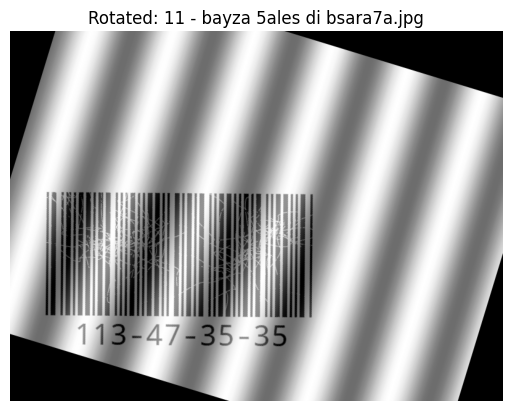


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 90.00 degrees, Count: 1
Processed kiwi.jpeg: Angle - 0.0


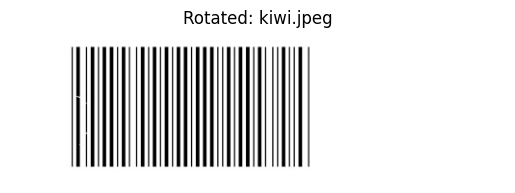


Top 10 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 179.00 degrees, Count: 20
Angle: 1.00 degrees, Count: 17
Angle: 90.00 degrees, Count: 2
Angle: 76.00 degrees, Count: 2
Angle: 77.00 degrees, Count: 1
Processed kiwi2.jpeg: Angle - 0.0


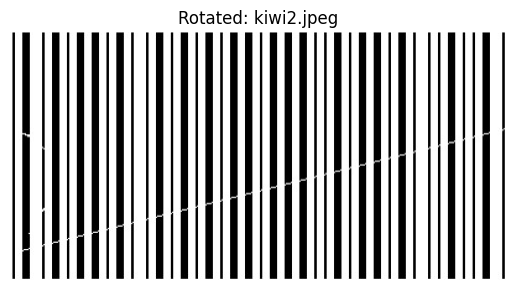

In [200]:
import os


for filename in os.listdir("TestCases/"):
    img_path = os.path.join("TestCases", filename)
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        
    try:
        angle = find_angle(img_gray)
        print(f"Processed {filename}: Angle - {angle}")
        if angle != 0.0:
            rotated_img = rotate_img(img_gray, angle)
        else:
            rotated_img = img_gray

        # Display the image
        plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
        plt.title(f"Rotated: {filename}")
        plt.axis('off')
        plt.show()
    except:
        print("error handling")






Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25
Angle: 80.00 degrees, Count: 24
Angle: 64.00 degrees, Count: 23
Angle: 78.00 degrees, Count: 22
Angle: 73.00 degrees, Count: 22
Angle: 90.00 degrees, Count: 22


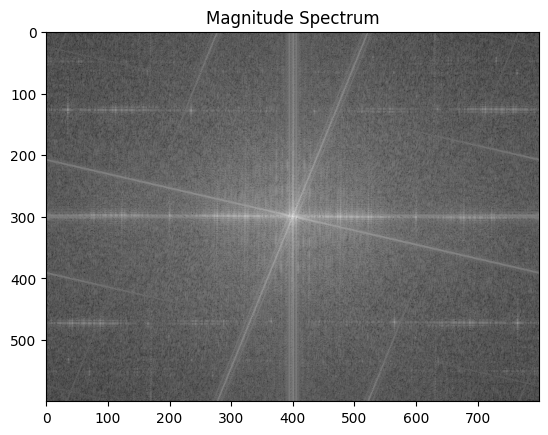

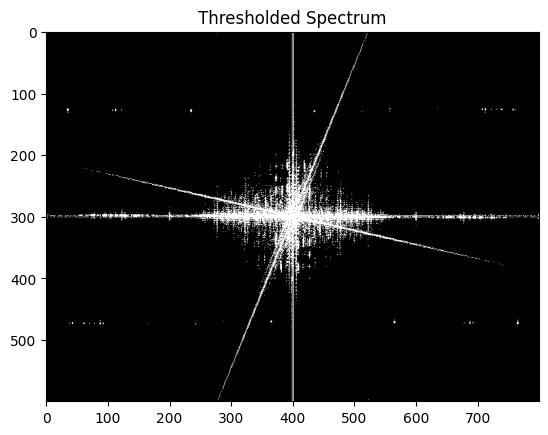

240400    18.091136
239594    16.362993
241206    16.362993
238794    15.942068
242006    15.942068
239599    15.898362
241201    15.898362
241200    15.620445
239600    15.620445
240399    15.537979
dtype: float64


In [ ]:
import pandas as pd


def find_freq_amplitudes(img_gray):
    dft_img = np.fft.fft2(img_gray)  # Assuming img_gray is the grayscale barcode image
    dft_shift = np.fft.fftshift(dft_img)
    magnitude_spectrum = np.log(np.abs(dft_shift) + 1)     
    # Convert the amplitude spectrum array to a DataFrame
    magnitude_df = pd.DataFrame(magnitude_spectrum)

    
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.show()
    _, thresh = cv2.threshold(magnitude_spectrum, 10, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title('Thresholded Spectrum')
    plt.show()

    # Flatten the DataFrame and get the top 10 values
    top_10_amplitudes = magnitude_df.values.flatten()  # Flatten to a 1D array
    top_10_values = pd.Series(top_10_amplitudes).nlargest(10)

    # Print top 10 amplitudes
    print(top_10_values)



angle = find_angle(img_gray3)
rotated_img=rotate_img(img_gray3,angle)
find_freq_amplitudes(rotated_img)









# dft_img = np.fft.fft2(img_gray3)  # Assuming img_gray is the grayscale barcode image
# dft_shift = np.fft.fftshift(dft_img)
# magnitude_spectrum = np.log(np.abs(dft_shift) + 1)


# plt.imshow(magnitude_spectrum, cmap='gray')
# plt.title('Magnitude Spectrum')
# plt.show()
# _, thresh = cv2.threshold(magnitude_spectrum, 10, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh, cmap='gray')
# plt.title('Thresholded Spectrum')
# plt.show()



# # Convert the amplitude spectrum array to a DataFrame
# magnitude_df = pd.DataFrame(magnitude_spectrum)

# # Flatten the DataFrame and get the top 10 values
# top_10_amplitudes = magnitude_df.values.flatten()  # Flatten to a 1D array
# top_10_values = pd.Series(top_10_amplitudes).nlargest(10)

# # Print top 10 amplitudes
# print(top_10_values)

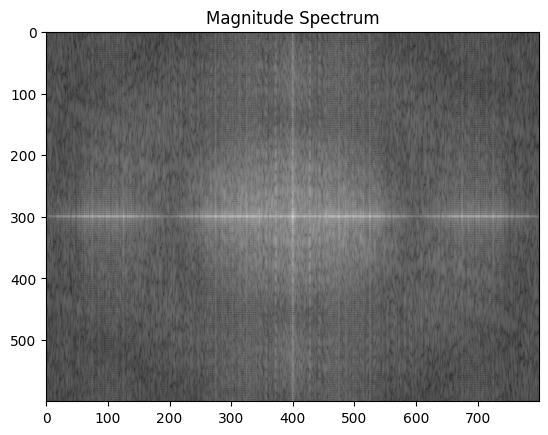

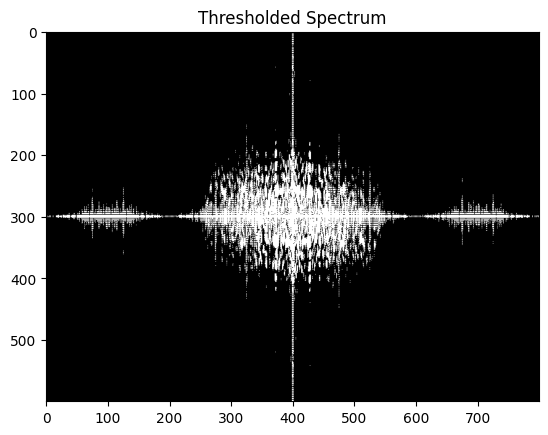

240400    18.519967
239600    16.062386
241200    16.062386
240399    15.858276
240401    15.858276
239601    15.617008
241199    15.617008
239599    15.609845
241201    15.609845
238800    15.197526
dtype: float64


In [80]:
find_freq_amplitudes(img_gray)

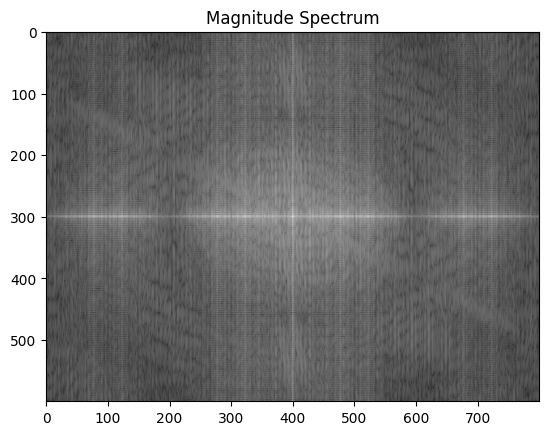

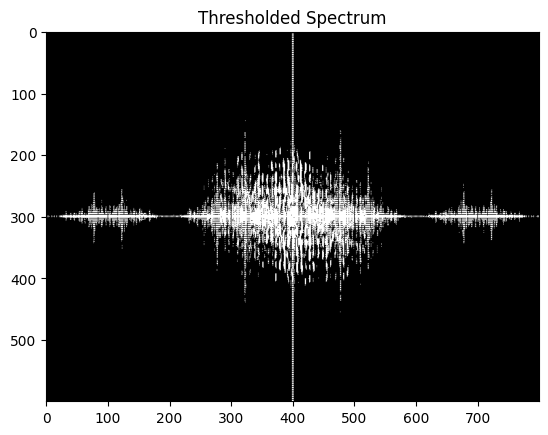

240400    18.515876
239600    16.110767
241200    16.110767
240399    15.901456
240401    15.901456
239601    15.675867
241199    15.675867
239599    15.671995
241201    15.671995
238800    15.294891
dtype: float64


In [81]:
find_freq_amplitudes(img_gray2)

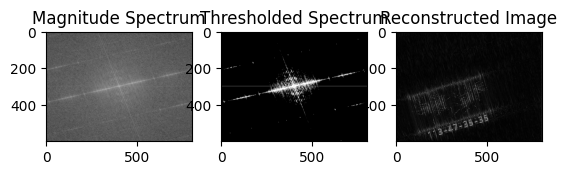

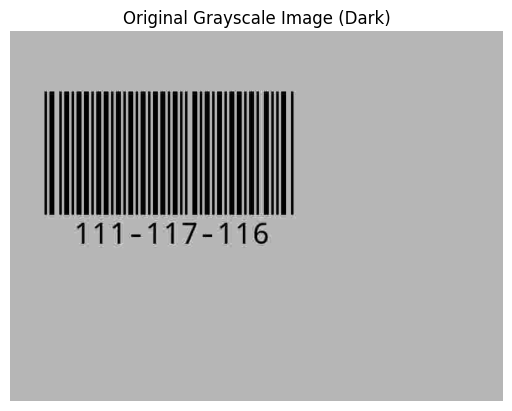

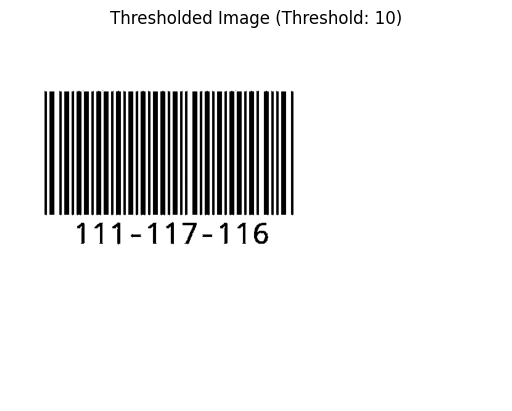

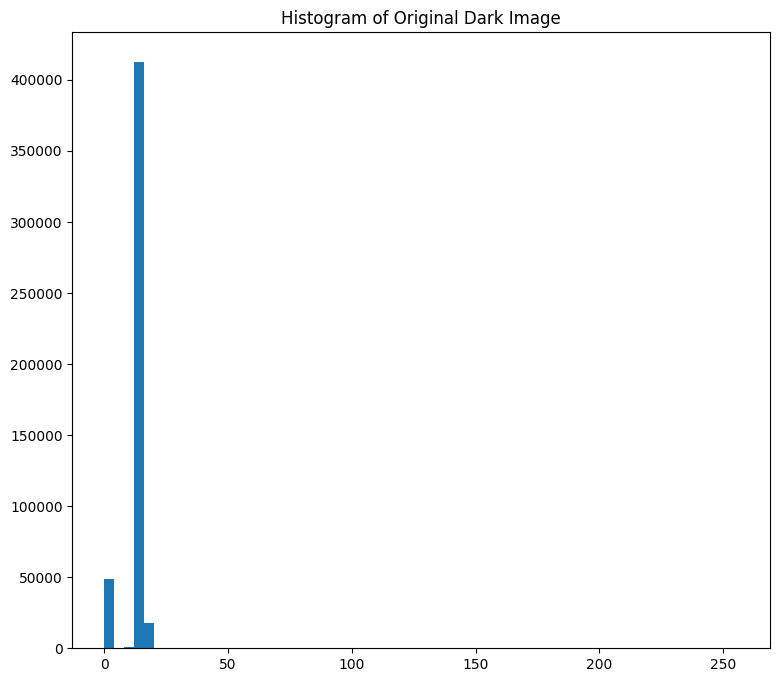

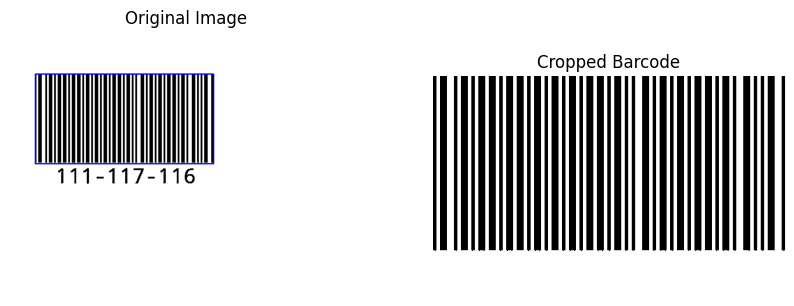

111100001111111100000000111100001111111100001111000011111111000011111111000011110000111111110000111111110000111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']


In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the dark image in grayscale
img_dark = cv2.imread("TestCases/05 - meen taffa el nour!!!.jpg", cv2.IMREAD_GRAYSCALE)

# Display the original grayscale image
plt.imshow(img_dark, cmap='gray')
plt.title("Original Grayscale Image (Dark)")
plt.axis('off')  # Hide axes
plt.show()

# Apply thresholding (Threshold value for dark image, 10)
_, img_dark_thresholded = cv2.threshold(img_dark, 10, 255, cv2.THRESH_BINARY)

# Display the thresholded image
plt.imshow(img_dark_thresholded, cmap='gray')
plt.title("Thresholded Image (Threshold: 10)")
plt.axis('off')  # Hide axes
plt.show()

# Optionally, display histogram of the original image
plt.figure(figsize=(9, 8))
plt.hist(img_dark.ravel(), bins=64, range=(0, 256))
plt.title("Histogram of Original Dark Image")
plt.show()

cropped_img=crop_image_contour_sorry_kiwi(img_dark_thresholded)

pixels_2=get_mean_pixels(cropped_img)

code=get_code(pixels_2)






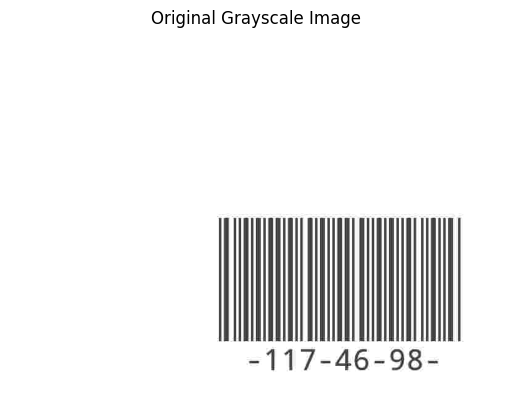

Top 5 bins: [252.0, 240.0, 236.0, 244.0, 248.0]
Average of the top 5 bins: 246.0
The image is biased towards bright (255) regions.
111100001111111100000000111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111100000000111111110000111100001111111100001111000011110000111111110000111111110000111100000000111111110000111100001111000011111111000011110000111111110000111100001111000011111111000011110000000011110000111100001111111100001111000011110000111111110000000011110
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']


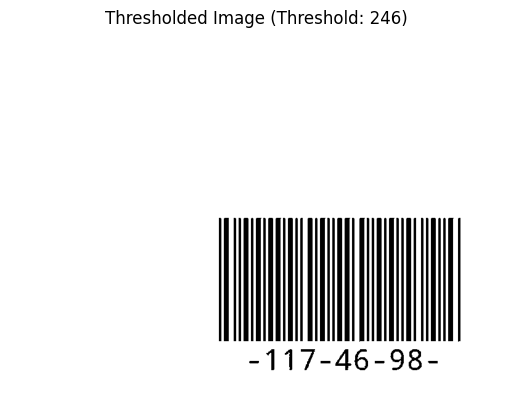

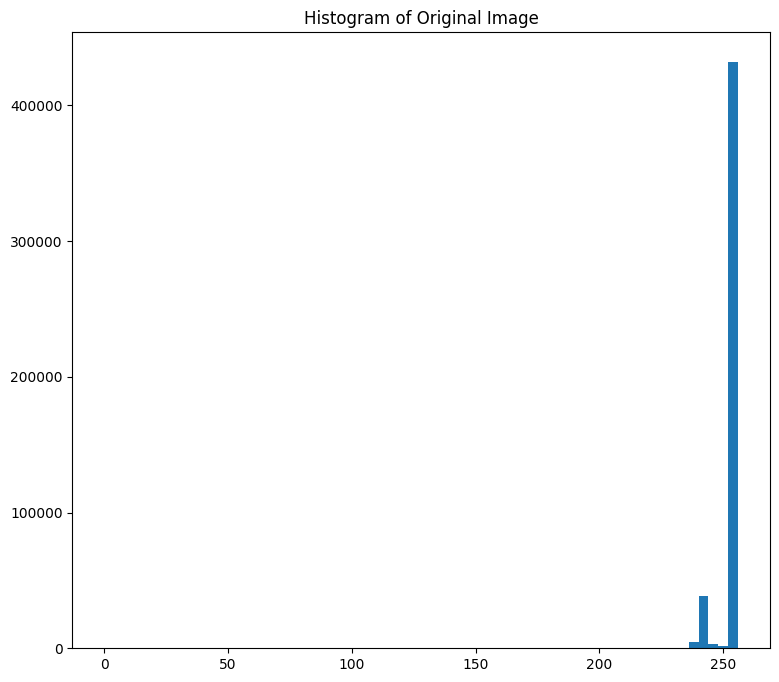

In [168]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale (assuming this is a bright image)
img_bright = cv2.imread("TestCases/06 - meen fata7 el nour 333eenaaayy.jpg", cv2.IMREAD_GRAYSCALE)

# Display the original grayscale image
plt.imshow(img_bright, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')  # Hide axes
plt.show()

# Apply thresholding (Threshold value for bright image, 250)


threshold=find_threshold_value(img_bright)
_, img_bright_thresholded = cv2.threshold(img_bright, threshold, 255, cv2.THRESH_BINARY)

cropped_img=crop_image_contour_sorry_kiwi(img_bright_thresholded)

pixels_2=get_mean_pixels(cropped_img,20)

code=get_code(pixels_2)

# Display the thresholded image
plt.imshow(img_bright_thresholded, cmap='gray')
plt.title("Thresholded Image (Threshold: 246)")
plt.axis('off')  # Hide axes
plt.show()

# Optionally, display histogram of the original image
plt.figure(figsize=(9, 8))
plt.hist(img_bright.ravel(), bins=64, range=(0, 256))
plt.title("Histogram of Original Image")
plt.show()

In [19]:
threshold=find_threshold_value(img_bright)
print(threshold)

Top 5 bins: [252.0, 240.0, 236.0, 244.0, 248.0]
Average of the top 5 bins: 246.0
The image is biased towards bright (255) regions.
246



Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 80
Angle: 152.00 degrees, Count: 78
Angle: 58.00 degrees, Count: 45
Angle: 65.00 degrees, Count: 42
Angle: 62.00 degrees, Count: 39
Angle: 64.00 degrees, Count: 39
Angle: 76.00 degrees, Count: 38
Angle: 71.00 degrees, Count: 38
Angle: 60.00 degrees, Count: 37
Angle: 68.00 degrees, Count: 37


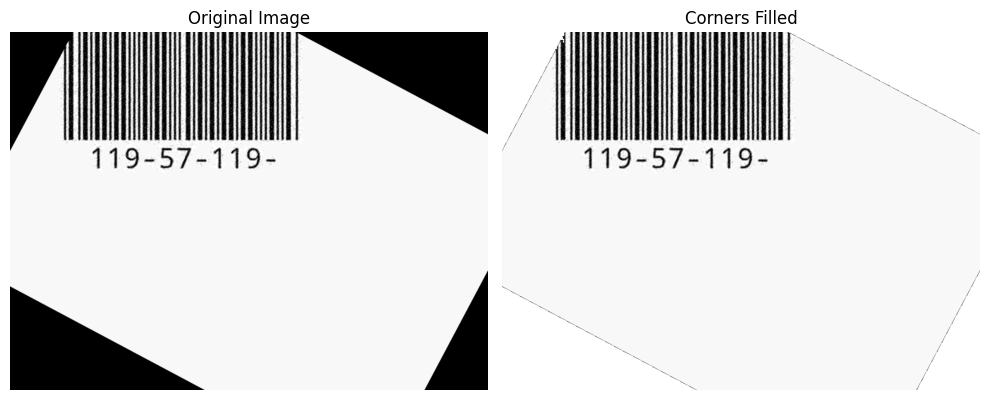

Top 5 bins: [248.0, 252.0, 0.0, 4.0, 8.0]
Average of the top 5 bins: 104.4
The image is biased towards bright (255) regions.
111100001111111100000000111100001111111100001111000011111111000011111111000011110000111111110000111111110000111100001111000011110000111111110000111100001111111100001111111100001111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011110000111111110000000011110000000000
['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']


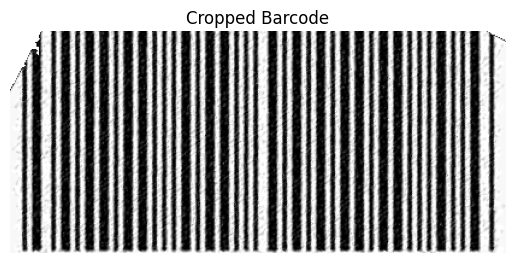

In [252]:
image=cv2.imread("TestCases/09 - e3del el soora ya3ammm.jpg", cv2.IMREAD_GRAYSCALE)
angle =find_angle(image)
rotated_img=rotate_img(image,angle)
filled_image=fill_corners(rotated_img)

threshold=find_threshold_value(filled_image)




cropped_img=crop_image_contour_sorry_kiwi(filled_image)







pixels=get_mean_pixels(cropped_img,40)

code=get_code(pixels)




Top 5 bins: [128.0, 120.0, 124.0]
Average of the top 5 bins: 126.0
The image is biased towards bright (255) regions.
126
11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111111110000000011110000111100001111000011111111000011110000111111110000111100001111111100001111000000001111000011111111000011110000111100001111111100001111000011111111000011110000111111110000111100001111000011111111000011110000111100001111000011111111000011110000111100001111111100000000111100
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']


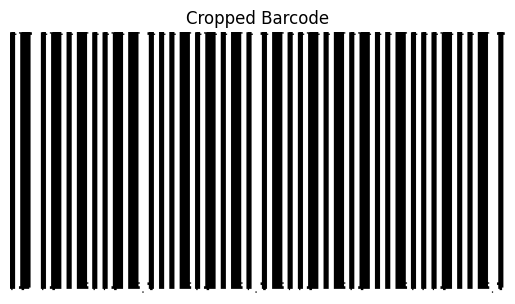

In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (grayscale)
image = cv2.imread('TestCases/10 - wen el kontraastttt.jpg', cv2.IMREAD_GRAYSCALE)


threshold=find_threshold_value(image)i

print(threshold)
_,image_thresholded=cv2.threshold(image,126,255,cv2.THRESH_BINARY)



cropped_img=crop_image_contour_sorry_kiwi(image_thresholded)

pixels_2=get_mean_pixels(cropped_img,40)

code=get_code(pixels_2)



In [125]:
pixels=get_mean_pixels(cropped_img)

0000000000011100001111111100000000111100001111111100001111000011111111000011111111000011110000111111110000111111110000111100001111000011110000111111110000111100001111111100001111111100001111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011110000111111110000000011110000000000


Top 5 bins: [208.0, 84.0, 212.0, 220.0, 100.0]
Average of the top 5 bins: 166.8
The image is biased towards bright (255) regions.
11110000111111110000000011110000111111110000111100001111111100001111111100001111000011111111000011111111000000001111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011111111000011111111000011110000111100000000111100001111111100001111000011111111000011110000111100001111111100000000111100
['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']


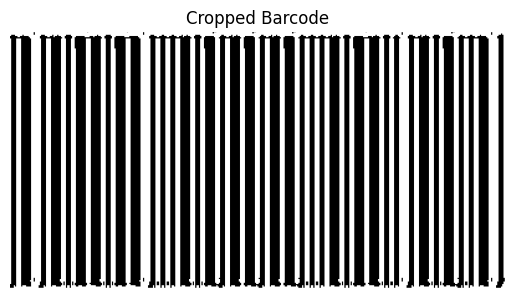

In [186]:
espresso_img=cv2.imread("TestCases/08 - compresso espresso.jpg",cv2.IMREAD_GRAYSCALE)

plt.imshow(espresso_img,cmap='gray')

threshold=find_threshold_value(espresso_img)

_,thresholded_juno=cv2.threshold(espresso_img,threshold,255,cv2.THRESH_BINARY)

plt.imshow(thresholded_juno,cmap='gray')


cropped_img=crop_image_contour_sorry_kiwi(thresholded_juno)

pixels_2=get_mean_pixels(cropped_img,40)

code=get_code(pixels_2)




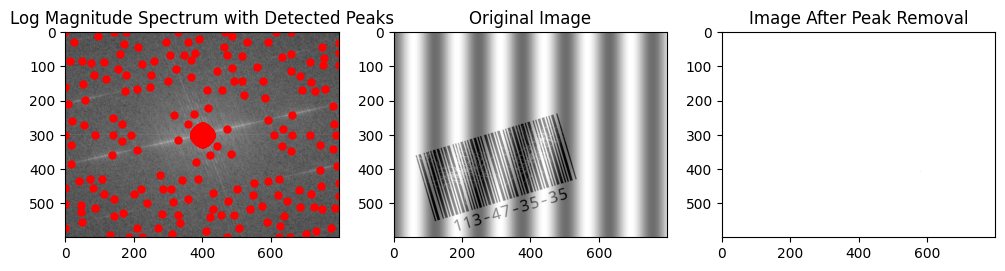

In [240]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, gaussian_filter

# Load the image
img = cv2.imread('TestCases/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)


# Apply Fourier Transform
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, gaussian_filter

# Load the image
img = cv2.imread('TestCases/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Fourier Transform
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Compute the magnitude spectrum
magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])

# Apply logarithmic transformation to the magnitude spectrum to enhance visibility of peaks
log_magnitude_spectrum = np.log1p(magnitude_spectrum)

# Smooth the spectrum (optional, to remove small variations)
sigma = 3  # Small sigma for moderate smoothing
smoothed_spectrum = gaussian_filter(log_magnitude_spectrum, sigma=sigma)

# Define the radius to exclude the center (low-frequency region)
center_radius = 50  # Radius of the low-frequency region to be excluded
height, width = log_magnitude_spectrum.shape
center_x, center_y = width // 2, height // 2

# Create a mask to exclude the center region
y, x = np.ogrid[:height, :width]
mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= center_radius ** 2

# Apply the mask to remove the central low-frequency region from peak detection
masked_spectrum = smoothed_spectrum.copy()
masked_spectrum[mask] = 0  # Set the central region to 0

# Detect local maxima using a maximum filter, but only on the masked spectrum
neighborhood_size = 40  # Adjust neighborhood size for sharper peak detection
local_max = (masked_spectrum == maximum_filter(masked_spectrum, size=neighborhood_size))

# Visualize the magnitude spectrum and the detected peaks
plt.figure(figsize=(12, 6))

# Magnitude Spectrum with Peaks
plt.subplot(131)
plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.title("Log Magnitude Spectrum with Detected Peaks")
# Plot peaks as red circles
peak_coords = np.column_stack(np.where(local_max == 1))  # Find the coordinates of the peaks
for y, x in peak_coords:
    plt.plot(x, y, 'ro', markersize=5)  # Mark the peaks in red

# Original Image
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.title("Original Image")

# Image After Peak Removal
dft_shift[local_max == 1] = 0  # Set detected peaks to zero
dft_ishift = np.fft.ifftshift(dft_shift)  # Inverse shift for proper inverse DFT
img_back = cv2.idft(dft_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# Normalize the image to fit within the display range
img_back = np.uint8(np.clip(img_back, 0, 255))

plt.subplot(133)
plt.imshow(img_back, cmap='gray')
plt.title("Image After Peak Removal")

plt.show()


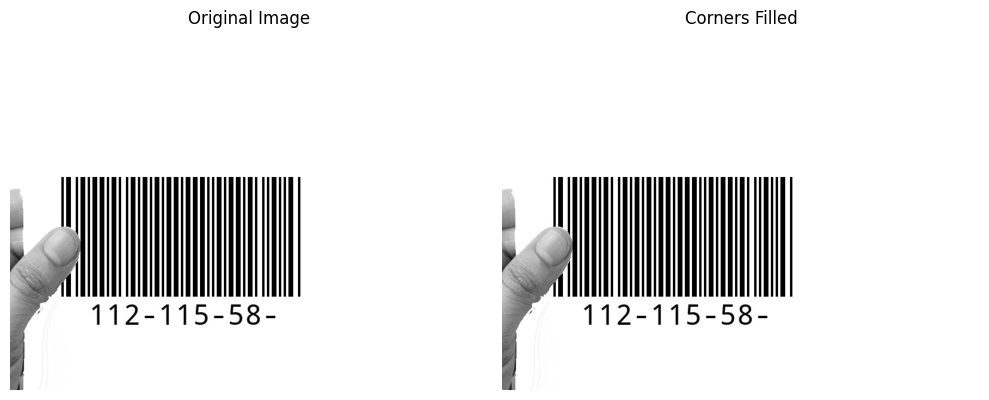

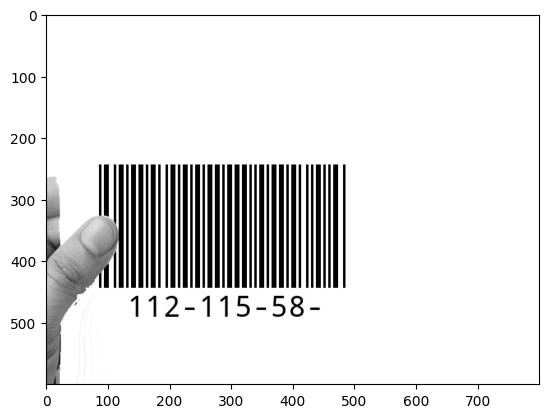

In [251]:
imagetry=cv2.imread("TestCases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg",cv2.IMREAD_GRAYSCALE)


imagetry=fill_corners(imagetry)

plt.imshow(imagetry,cmap='gray')





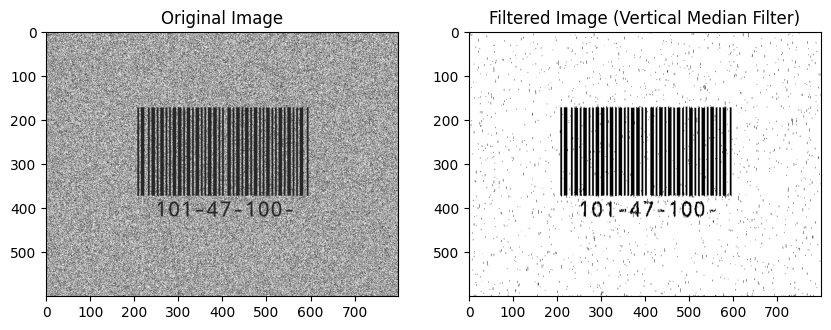

In [281]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# Load the barcode image with salt-and-pepper noise
image = cv2.imread('TestCases/07 - mal7 w felfel.jpg', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully

    # Apply a vertical median filter by specifying size (kernel size)
    # The size should be odd for a better median computation
kernel_size = 5

 #Apply horizontal blur first
blurred_image = cv2.blur(image, (1, 7))

# Apply vertical median filter using a custom kernel size
filtered_image = median_filter(blurred_image, size=(3, 1))  # Size=(3 rows, 1 column





_,filtered_image=cv2.threshold(filtered_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Display the original and filtered images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Filtered Image (Vertical Median Filter)")
plt.imshow(filtered_image, cmap='gray')
plt.show()


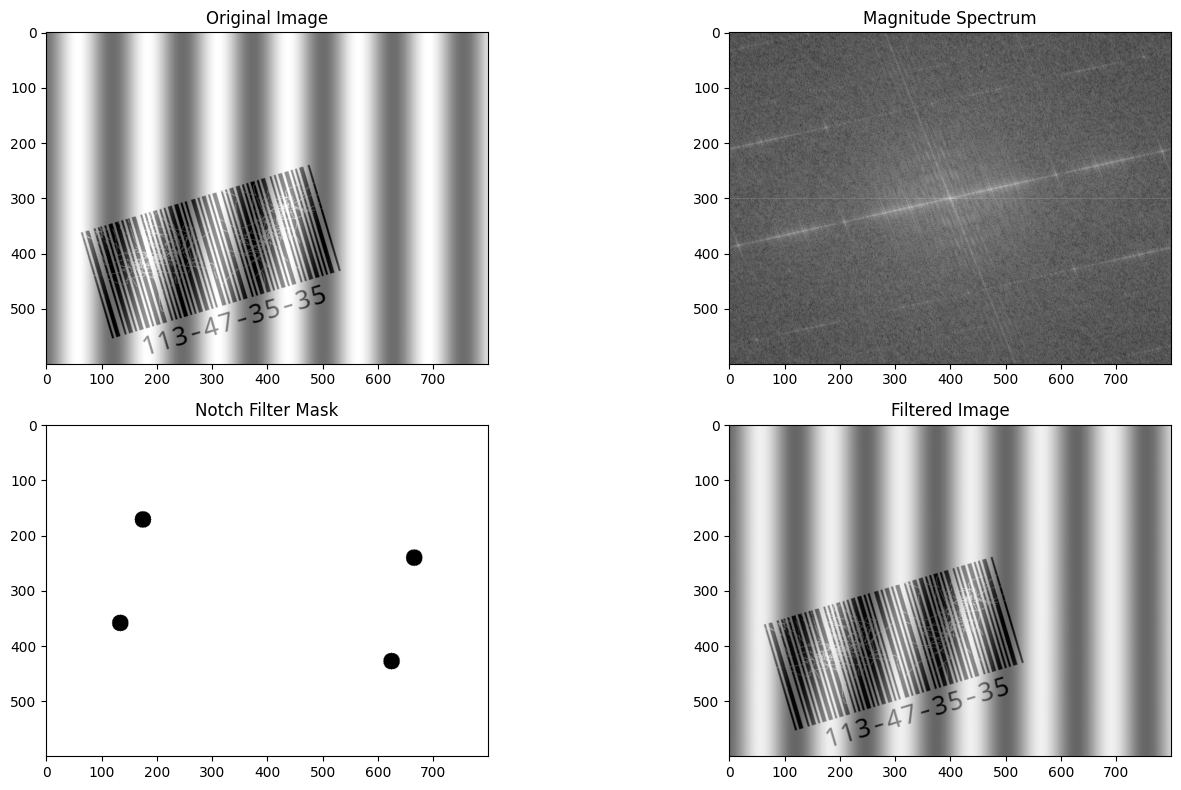

In [290]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

def notch_filter(shape, coordinates, notch_radius=10, keep_center=True):
    """
    Create a notch filter mask to suppress frequencies at specified coordinates.
    
    :param shape: Shape of the Fourier transform (rows, cols)
    :param coordinates: List of coordinates to suppress (list of tuples)
    :param notch_radius: Radius of suppression around each coordinate
    :param keep_center: Whether to keep the center (low frequencies) untouched
    :return: Notch filter mask
    """
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.ones((rows, cols), dtype=np.float32)
    
    for coord in coordinates:
        y, x = coord
        # Skip the center if keep_center is True
        if keep_center and (abs(y - center_row) < notch_radius and abs(x - center_col) < notch_radius):
            continue
        cv2.circle(mask, (x, y), notch_radius, 0, -1)  # Draw a black circle at each peak

    return mask

# Load the grayscale image
image = cv2.imread('TestCases/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Compute the Fourier Transform and shift the zero-frequency component
dft = np.fft.fft2(image)
dft_shift = np.fft.fftshift(dft)

# Get the magnitude spectrum
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)  # Add 1 to avoid log(0)

# Step 2: Detect local maxima in the spectrum
coordinates = peak_local_max(magnitude_spectrum, min_distance=100, threshold_abs=20)

# Step 3: Create and apply the notch filter
notch_radius = 15
mask = notch_filter(dft_shift.shape, coordinates, notch_radius=notch_radius, keep_center=True)
filtered_dft = dft_shift * mask

# Step 4: Inverse Fourier Transform to return to the spatial domain
dft_ishift = np.fft.ifftshift(filtered_dft)
filtered_image = np.fft.ifft2(dft_ishift)
filtered_image = np.abs(filtered_image)

# Display the results
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Magnitude Spectrum")
plt.imshow(magnitude_spectrum, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Notch Filter Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap='gray')

plt.tight_layout()
plt.show()
